# Model Predictive Control (MPC) for a Cascaded Tanks System


This notebook introduces the basics of Model Predictive Control (MPC) by applying it to a cascaded tanks system. 
We will model the dynamics of two connected tanks where the second tank’s water level is controlled based on the water level in both tanks. 
The notebook covers:

1. **Introduction to MPC and Cascaded Tanks System**
2. **System Modeling**
3. **MPC Problem Formulation**
4. **Simulation and Results**

Let's start with an overview of the cascaded tanks system.


## 1. Introduction to MPC and Cascaded Tanks System


### What is Model Predictive Control?
Model Predictive Control (MPC) is an advanced method of process control that solves an optimization problem at each time step to predict and optimize future behavior. It is used for controlling systems with constraints, such as physical limits on actuators or states.

### Cascaded Tanks System
In this example, we will consider a system consisting of two connected water tanks. Water flows from the first tank (Tank 1) into the second tank (Tank 2). The goal is to control the water level in Tank 2 by manipulating the inflow to Tank 1. 

The dynamics of the system are defined as:
- **Inflow to Tank 1**: Control variable (`u`)
- **Height of water in Tank 1**: `h1`
- **Height of water in Tank 2**: `h2`
- **Outflow from Tank 1 to Tank 2**: Proportional to `h1`
- **Outflow from Tank 2**: Proportional to `h2`

The equations can be derived via Bernoulli's Equation and via mass balances and can be shown as follows:

\begin{equation}
\frac{dh_1}{dt} = \frac{u - a_1 \sqrt{h_1}}{A_1}
\end{equation}

\begin{equation}
\frac{dh_2}{dt} = \frac{a_1 \sqrt{h_1} - a_2 \sqrt{h_2}}{A_2}
\end{equation}



## 2. System Modeling

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Parameters for the tanks
A1 = 1.0   # Cross-sectional area of Tank 1
A2 = 1.0   # Cross-sectional area of Tank 2
a1 = 0.5   # Outflow coefficient of Tank 1
a2 = 0.5   # Outflow coefficient of Tank 2
dt = 0.1   # Time step for simulation

# System dynamics
def tank_dynamics(h, u):
    h1, h2 = h
    dh1_dt = (u - a1 * np.sqrt(h1)) / A1
    dh2_dt = (a1 * np.sqrt(h1) - a2 * np.sqrt(h2)) / A2
    return np.array([dh1_dt, dh2_dt])

# Discrete-time model
def simulate_step(h, u):
    return h + dt * tank_dynamics(h, u)


## 3. MPC Problem Formulation


The objective of the MPC is to control the inflow `u` to maintain a desired water level in Tank 2 (`h2_ref`). At each time step, the MPC solves an optimization problem to find the best sequence of control actions that minimize a cost function over a prediction horizon.

### Cost Function
We will define a quadratic cost function that penalizes deviations of `h2` from its reference value.  You can also add in terms that prevent large control actions, which is common for MPCs, though that is left out for this introduction to MPCs.
$$ J = \sum_{k=0}^{N-1} \left( (h2_k - h2_{\text{ref}})^2 \right) $$
where:
- `C_Horizon`: Control horizon
- `P_Horizon`: Prediction horizon
- `h2_ref`: Setpoint level for Tank 2

Note that there are two horizons, the control and prediction horizons.  The control horizon runs the system and an optimization algorithm that determines the best `u` value for that time step to get to the setpoint.  The prediction horizon is the number of total steps predictions are made for and is always larger than the control horizon.  These steps use the last value from the control horizon's u values to run the system and the idea here is to choose a value where the flowrate does not need to change in order to keep at the setpoint.

### Constraints
The MPC will also need to respect constraints on `u` and the tank levels because of the optimization that happens:
- `u_min <= u <= u_max`
- `h1_min <= h1 <= h1_max`
- `h2_min <= h2 <= h2_max`


In [2]:
from scipy.optimize import minimize

# Control and Prediction horizon
C_Horizon = 20  # Number of future time steps over which control updates are made
P_Horizon = 40  # Number of future time steps over which predictions are made

# Reference level for Tank 2
h2_ref = 1.0  # Target water level for Tank 2

# Constraints on u (control input)
u_min = 0.0  # Minimum possible inflow rate
u_max = 2.0  # Maximum possible inflow rate


# Cost function for MPC
def mpc_cost(u_seq, h0):
    """
    Calculates the cost of a given control sequence for the cascaded tanks system.

    Parameters:
    -----------
    u_seq : array-like
        A sequence of control inputs (inflow rates) over the prediction horizon.
        This is the variable being optimized by the MPC.
    h0 : array-like
        The initial state of the system, representing the water levels in both tanks.
        h0[0] = h1 (water level in Tank 1)
        h0[1] = h2 (water level in Tank 2)

    Returns:
    --------
    cost : float
        The total cost associated with the control sequence `u_seq`. The cost is a 
        sum of deviations of the water level in Tank 2 from its reference value 
        (h2_ref) and a penalty on the magnitude of the control input.
    """
    h = h0.copy()  # Make a copy of the initial state to simulate future states
    cost = 0.0  # Initialize the cost accumulator
    
    # Iterate over the control horizon
    for u in u_seq:
        # Update the state of the system using the current control input
        h = simulate_step(h, u)
        # Calculate the cost at each step:
        # Penalize the deviation of h2 (Tank 2 water level) from the reference (h2_ref)
        cost += (h[1] - h2_ref)**2 

    # Iterate over the prediction horizon
    for _ in range(P_Horizon - C_Horizon):
        # Update the state of the system using the last control input
        h = simulate_step(h, u_seq[-1])
        
        # Calculate the cost at each step:
        # Penalize the deviation of h2 (Tank 2 water level) from the reference (h2_ref)
        cost += (h[1] - h2_ref)**2 
    
    return cost

# Bounds for the control sequence
# Each element in the control sequence `u_seq` must lie within [u_min, u_max]
bounds = [(u_min, u_max) for _ in range(C_Horizon)]

# Function to solve the MPC optimization problem
def solve_mpc(h0):
    """
    Solves the MPC optimization problem to find the optimal control sequence.

    Parameters:
    -----------
    h0 : array-like
        The current state of the system, representing the water levels in both tanks.
        h0[0] = h1 (water level in Tank 1)
        h0[1] = h2 (water level in Tank 2)

    Returns:
    --------
    u_optimal_seq : array-like or None
        The optimal sequence of control inputs over the prediction horizon that 
        minimizes the cost function. If the optimization is unsuccessful, returns None.
    """
    # Initialize the control sequence with zeros (starting guess)
    u_init = np.ones(C_Horizon)
    
    # Solve the optimization problem using `minimize` from scipy
    # The objective is to minimize the cost function `mpc_cost`
    # `args=(h0,)` passes the initial state `h0` as a fixed argument to `mpc_cost`
    result = minimize(mpc_cost, u_init, args=(h0,), bounds=bounds)
    
    # Check if the optimizer successfully found a solution
    if result.success:
        return result.x  # Return the optimal sequence of control inputs
    else:
        return None  # Return None if the optimization failed

## 4. Simulation and Results

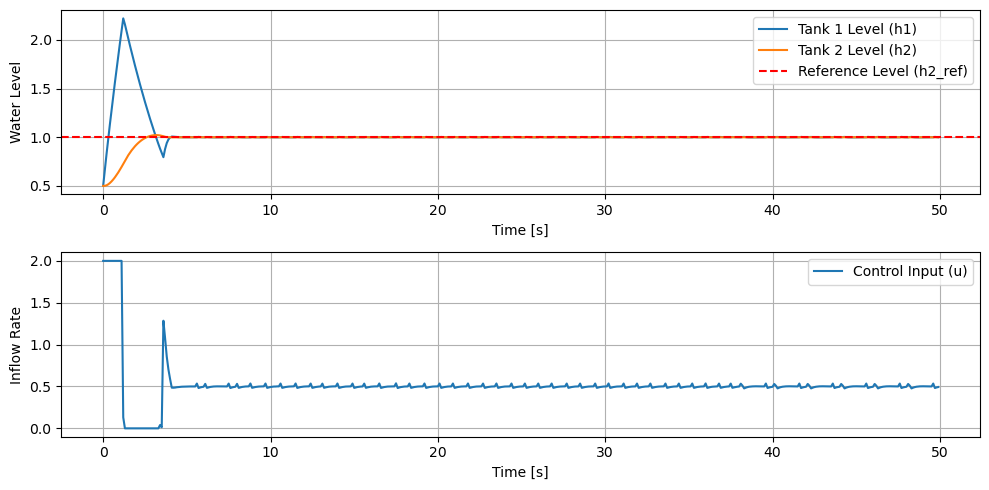

In [3]:
# Initial states of the tanks
h0 = np.array([0.5, 0.5])
"""
h0 : array-like
    The initial state vector of the system representing the water levels in both tanks.
    h0[0] = Initial water level in Tank 1 (0.5 meters)
    h0[1] = Initial water level in Tank 2 (0.5 meters)
"""

# Simulation settings
T_sim = 50  # Total simulation time in seconds
num_steps = int(T_sim / dt)  # Number of simulation steps based on time step (dt)
"""
T_sim : float
    The total duration for which the simulation will be run.
num_steps : int
    The total number of discrete time steps in the simulation.
"""

# Arrays to store simulation results
h_history = np.zeros((num_steps, 2))  # Array to store water levels over time (h1, h2)
u_history = np.zeros(num_steps)  # Array to store control input (inflow rate) over time
"""
h_history : numpy array
    A 2D array to record the water levels in both tanks at each time step.
    Shape: (num_steps, 2), where each row represents [h1, h2] at a given time.
u_history : numpy array
    A 1D array to record the control inputs (inflow rates) applied at each time step.
    Shape: (num_steps,), where each element corresponds to the control input `u` at a time step.
"""

# Initialize the state of the tanks for the simulation
h = h0.copy()  # Create a copy of the initial state to update during the simulation

# Run the simulation loop for each time step
for t in range(num_steps):
    # Solve MPC to find the optimal control action sequence over the prediction horizon
    u_optimal_seq = solve_mpc(h)
    """
    u_optimal_seq : array-like
        A sequence of optimal control inputs over the prediction horizon.
        The first control input in this sequence is applied to the system.
    """
    
    # Apply the first control action in the optimal sequence to the system
    u = u_optimal_seq[0]  # Only use the first control action for the current time step
    """
    u : float
        The control input (inflow rate) to be applied to Tank 1 at the current time step.
    """

    # Save data for plotting and analysis
    h_history[t] = h  # Store the current water levels in both tanks
    u_history[t] = u  # Store the current control input
    
    # Update the state of the tanks based on the applied control input
    h = simulate_step(h, u)
    """
    h : array-like
        Updated state vector of the system after applying the control input `u`.
        Represents the new water levels in Tank 1 and Tank 2 at the next time step.
    """


# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(num_steps) * dt, h_history[:, 0], label='Tank 1 Level (h1)')
plt.plot(np.arange(num_steps) * dt, h_history[:, 1], label='Tank 2 Level (h2)')
plt.axhline(h2_ref, color='r', linestyle='--', label='Reference Level (h2_ref)')
plt.xlabel('Time [s]')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(num_steps) * dt, u_history, label='Control Input (u)')
plt.xlabel('Time [s]')
plt.ylabel('Inflow Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In the plots above, you can see how the MPC controls the inflow rate `u` to maintain the desired water level in Tank 2. The first plot shows the water levels in both tanks, and the second plot shows the control input over time.

This example demonstrates a basic implementation of MPC for a cascaded tanks system. However, due to the fact that the MPC isn't penalized for large changes in control variable (inlet flow rate), it makes large swings quickly.

# MPC Object Derivation
To help with this lab, an MPC object was created in python in order to assist with the MPC control action. Below is a derivation of the object.  This object follows all the same ideas as the derivation above and can be found in the helper function file; however, it gives places where machine learning functions can be used in place of the explicit system dynamics shown at the begining of this notebook.